# Notebook de Exemplos: Interpolação de Pontos na Reta Real

Este notebook demonstra o uso das seguintes funções de interpolação:

1.  `lin_interp`: Realiza a interpolação linear por partes entre os pontos.

2.  `poly_interp`: Calcula o polinômio interpolador (Interpolação Polinomial) pelo Método de Lagrange.

3.  `hermite_interp`: Calcula o polinômio interpolador de Hermite (usando valores e derivadas).

4.  `vandermond_interp` (extra): Calcula o polinômio interpolador pelo Método de Vandermonde.

Todas as funções também demonstram a representação gráfica dos pontos e do polinômio/função interpoladora.

# Código - Interpolação Linear

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

def _ordenar_coordenadas(x: list, y: list) -> list:
    """Ordena as coordenadas mantendo 'pareamento'.
    
    Pega as coordenadas x e y de cada ponto, ordena em ordem crescente
    as coordenadas x e mantém pareamento com y. Função privada, auxiliar
    da função principal lin_interp.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.

    Returns:
        x_ord: lista das coordenadas x em ordem crescente.
        y_ord: lista das coordenadas y, pareadas com as coordenadas x.
    """
    x_np = np.array(x)
    y_np = np.array(y)

    idx = np.argsort(x_np)

    x_ord = x_np[idx]
    y_ord = y_np[idx]

    return x_ord, y_ord

def _plotar(x: list,
            y: list,
            f: Callable,
            titulo: str = 'Gráfico'):
    """Plotagem de pontos e de uma função.

    Plotagem dos pontos indicados pelas coordenadas x e y, seguindo a
    função f. Função privada, auxiliar da função principal lin_interp.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.
        f: função que será plotada.

    Returns:
        None
    """
    x_points = np.linspace(x[0], x[-1], 500)
    y_points = [f(xp) for xp in x_points]

    _, ax = plt.subplots()
    ax.scatter(x, y, color = 'red', label = 'Dados')
    ax.plot(x_points, y_points,'b-', linewidth=2, label = 'Interpolação Linear por Partes')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(titulo)
    ax.grid(True)
    plt.show()

    return

def lin_interp(x: list,
               y: list,
               plot: bool = False
               ) -> Callable:
    """Interpolação linear por partes a partir dos pontos dados.

    Essa função ordena pontos a partir da ordem crescente das
    coordenadas x. Em seguida, cria retas descritas pela nova
    função f, que 'ligam' os pontos descritos pelas coordenadas x e y.
    É permitida extrapolação. Por fim, caso 'plot = True', há uma
    plotagem do gráfico correspondente.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.
        plot: indica se deve haver a plotagem (True) ou não (False).

    Returns:
        f: função de interpolação linear por partes
    """

    # Ordenação das coordenadas x em ordem crescente
    x, y = _ordenar_coordenadas(x, y)

    # Definição da função de interpolação
    def f(x1: float) -> float:
        if x1 < x[0]: # Caso fora do intervalo, continua a reta mais próxima
            a = (y[1] - y[0])/(x[1] - x[0])
            b = y[0]
                    
            y1 = b + (x1 - x[0]) * a 
            return y1
        elif x1 > x[-1]: # Caso fora do intervalo, continua a reta mais próxima
            a = (y[-1] - y[-2])/(x[-1] - x[-2])
            b = y[-2]
                    
            y1 = b + (x1 - x[-2]) * a
            return y1
        else:
            for i in range (1, len(x)): # Busca intervalo do número x1 para atribuir valor f(x1)
                if x[i] >= x1 >= x[i-1]:
                    a = (y[i] - y[i-1])/(x[i] - x[i-1])
                    b = y[i-1]
                    
                    y1 = b + (x1 - x[i-1]) * a # Aproximação linear
                    
                    return y1

    # Plotagem do gráfico correspondente à função f
    if plot:
        _plotar(x, y, f, 'Interpolação Linear por Partes')

    return f

Exemplo 1

Segue abaixo as coordenadas x e y dos pontos do exemplo 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[34, 12, 60, 35, 7, 23, 6, 50, 10, 4, 21]


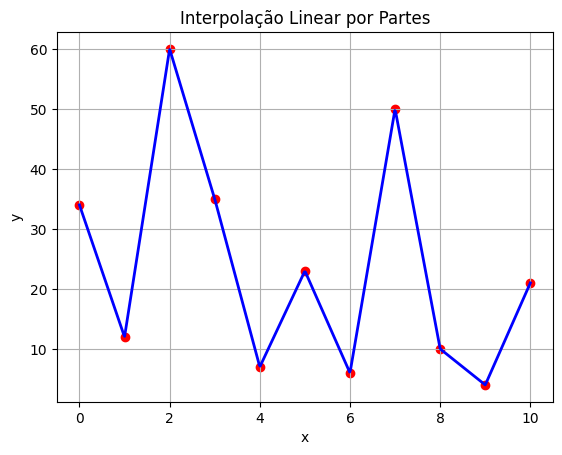

O valor interpolado em 1.5 é p(num)=36.0
O valor interpolado em 2.8 é p(num)=40.0
O valor interpolado em 3.9 é p(num)=9.8
O valor interpolado em 5.7 é p(num)=11.1
O valor interpolado em 9.1 é p(num)=5.7
O valor interpolado em 11.1 é p(num)=39.7
O valor interpolado em 15 é p(num)=106.0

Note que extrapolação é permitida

--------------

Exemplo 2

Perceba que, mesmo ao mudar a ordem das coordenadas, o gráfico continua o mesmo

Segue abaixo as coordenadas x e y dos pontos do exemplo 2
[0, 1, 10, 2, 4, 7, 5, 6, 8, 9, 3]
[34, 12, 21, 60, 7, 50, 23, 6, 10, 4, 35]


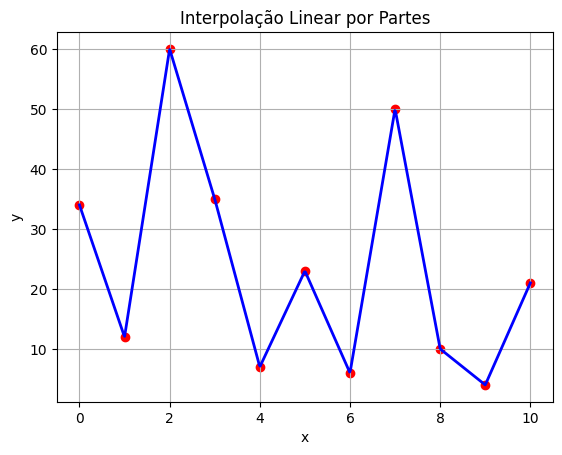

In [2]:
print('Exemplo 1')

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [34, 12, 60, 35, 7, 23, 6, 50, 10, 4, 21]

print('\nSegue abaixo as coordenadas x e y dos pontos do exemplo 1')
print(x)
print(y)

p = lin_interp(x, y, plot = True)

teste = [1.5, 2.8, 3.9, 5.7, 9.1, 11.1, 15]
if p:
    for num in teste:
        print(f'O valor interpolado em {num} é p(num)={round(p(num),2)}')

print('\nNote que extrapolação é permitida')

print('\n--------------\n')
print('Exemplo 2')
print('\nPerceba que, mesmo ao mudar a ordem das coordenadas, o gráfico continua o mesmo')
x1 = [0, 1, 10, 2, 4, 7, 5, 6, 8, 9, 3]
y1 = [34, 12, 21, 60, 7, 50, 23, 6, 10, 4, 35]
print('\nSegue abaixo as coordenadas x e y dos pontos do exemplo 2')
print(x1)
print(y1)

f = lin_interp(x1, y1, plot = True)

# Código - Vandermonde

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

def _ordenar_coordenadas(x: list, y: list) -> list:
    """Ordena as coordenadas mantendo 'pareamento'.
    
    Pega as coordenadas x e y de cada ponto, ordena em ordem crescente
    as coordenadas x e mantém pareamento com y. Função privada, auxiliar
    da função principal lin_interp.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.

    Returns:
        x_ord: lista das coordenadas x em ordem crescente.
        y_ord: lista das coordenadas y, pareadas com as coordenadas x.

    Raises:
        RuntimeError: caso x e y não tenham mesma quantidade de elementos.
    """
    if len(x) != len(y):
        raise RuntimeError(f"x e y devem ter a mesma quantidade de elementos")
    
    x_np = np.array(x)
    y_np = np.array(y)

    idx = np.argsort(x_np)

    x_ord = x_np[idx]
    y_ord = y_np[idx]

    return x_ord, y_ord

def _random_sample(intv: list, N: int) -> np.array:
    """Cria uma amostra aleatória.
    
    Args:
        intv: intervalo da amostra.
        N: número de amostras.

    Returns:
        Lista numpy.array das amostras.
    """
    r = np.random.uniform(intv[0], intv[1], N-2)
    r.sort()
    return np.array([intv[0]] + list(r) + [intv[1]])

def _error_pol(f: Callable,
               P: Callable,
               intv: list,
               n: int = 1000) -> np.array:
    """Calcula o erro médio e o erro máximo
    
    Args:
        f: função analisada.
        P: função idealizada.
        intv: intervalo analisado.
        n = quantidade de amostras.

    Reuturns:
        Erro médio.
        Erro máximo.
    """
    x = _random_sample(intv, n)
    error = np.abs(f(x)-P(x))
    return np.sum(error)/n, np.max(error)

def _plotar(x: list,
            y: list,
            f: Callable,
            titulo: str = 'Gráfico',
            f_ideal: Callable = None):
    """Plotagem de pontos e de uma função.

    Plotagem dos pontos indicados pelas coordenadas x e y, seguindo a
    função f. Caso haja uma função ideal, ela também é plotada, e seu
    erro é calculado. Função privada, auxiliar da função principal lin_interp.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.
        f: função que será plotada.
        titulo: titulo do gráfico que será plotado.
        f_ideal: função ideal (caso tenha).

    Returns:
        None
    """
    x_points = np.linspace(x[0], x[-1], 500)
    y_points = [f(xp) for xp in x_points]

    _, ax = plt.subplots()
    ax.scatter(x, y, color = 'red', label = 'Dados')
    ax.plot(x_points, y_points, 'b-', linewidth=2, label = 'Interpolação Polinomial (Vandermonde)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)

    if f_ideal: # Caso exista uma função ideal, o erro médio é calculado e mostrado na plotagem
        y_ideal = [f_ideal(xp) for xp in x_points]
        intv = [x[0], x[1]]
        erroMedio, erroMax = _error_pol(f, f_ideal, intv, n= 1000)
        ax.set_title(titulo+f' - Erro Médio = {erroMedio:2.4f} - Erro Máximo = {erroMax:2.4f}')
        ax.plot(x_points, y_ideal, color = 'g', label = 'Função ideal')
    else:
        ax.set_title(titulo)
    
    ax.legend()
    plt.show()

    return

def vandermond_interp(x: list,
                      y: list,
                      plot: bool = False,
                      f_ideal: Callable = None) -> Callable:
    """Interpolação polinomial pelo método de Vandermonde

    Essa função ordena pontos a partir da ordem crescente das
    coordenadas x. Em seguida, cria matriz de Vandermonde e retorna
    a solução algébrica para, assim, conseguir os coeficientes do
    polinômio interpolado. Caso haja uma função ideal, também é calculado
    o erro, que é representado no plot. Por fim, caso 'plot = True', há uma
    plotagem do gráfico correspondente. Por padrão, 'plot = False',
    ou seja, por padrão não há a plotagem.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.
        plot: indica se deve haver a plotagem (True) ou não (False).
        f_ideal: função ideal, caso queira fazer comparação de erros.

    Returns:
        f: função de interpolação linear por partes.

    Raises:
        RuntimeError: caso x e y não tenham mesma quantidade de elementos.
    """

    # Verifica se x e y têm a mesma quantidade de elementos
    if len(x) != len(y):
            raise RuntimeError(f"x e y devem ter a mesma quantidade de elementos")
    
    # Ordenação das coordenadas x em ordem crescente
    x, y = _ordenar_coordenadas(x, y)
    
    n = len(x)
    matrix_vandermond = np.ones([n, n]) # Criação da matriz de Vandermonde com uns
    for i in range(n): # Eleva cada elemento da matriz ao seu devido expoente
        for k in range(1, n):
            matrix_vandermond[i][k] = matrix_vandermond[i][k-1] * x[i]
    
    coef = np.linalg.solve(matrix_vandermond, y)
    
    # Definição da função de interpolação
    def f(x1: float) -> float:
        y1 = 0
        for a in coef[::-1]: # Método de Horner para calcular valores de polinômios
            y1 = a + y1*x1

        return y1

    # Plotagem do gráfico correspondente à função f
    if plot:
        if f_ideal: # Caso exista uma função ideal, o erro é "plotado" no título
            _plotar(x, y, f, 'Interpolação Polinomial (Vandermonde)', f_ideal= f_ideal)
        else:
            _plotar(x, y, f, 'Interpolação Polinomial (Vandermonde)')

    return f

Exemplo 1

Segue abaixo as coordenadas x e y dos pontos do exemplo 1
[0, 1, 2, 3]
[1, 2, 0, 4]


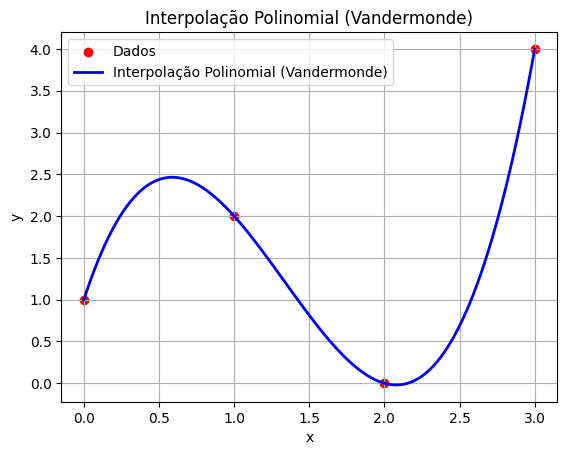

O valor interpolado em 1.5 é p(num)=0.81
O valor interpolado em 2.8 é p(num)=2.29
O valor interpolado em 3.9 é p(num)=20.17
O valor interpolado em 5.7 é p(num)=115.2
O valor interpolado em 9.1 é p(num)=684.55
O valor interpolado em 11.1 é p(num)=1374.24
O valor interpolado em 15 é p(num)=3796.0

Note que extrapolação é permitida

--------------

Exemplo 2

Perceba que, mesmo ao mudar a ordem das coordenadas, o gráfico continua o mesmo

Segue abaixo as coordenadas x e y dos pontos do exemplo 2
[3, 0, 2, 1]
[4, 1, 0, 2]


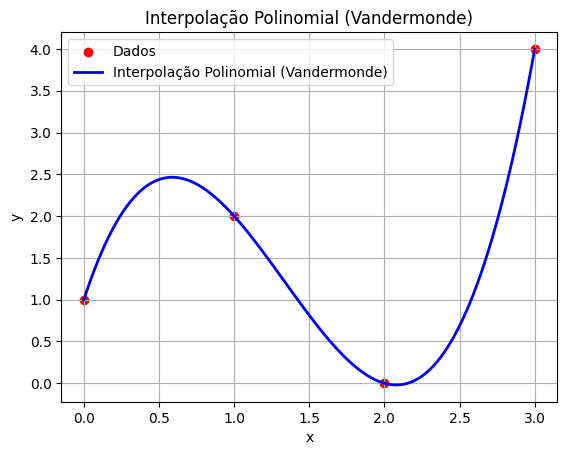


--------------

Exemplo 3
[-6.283185307179586, -3.141592653589793, -1.5707963267948966, 0, 1.5707963267948966, 3.141592653589793, 6.283185307179586]
[0, 0, -1, 0, 1, 0, 0]


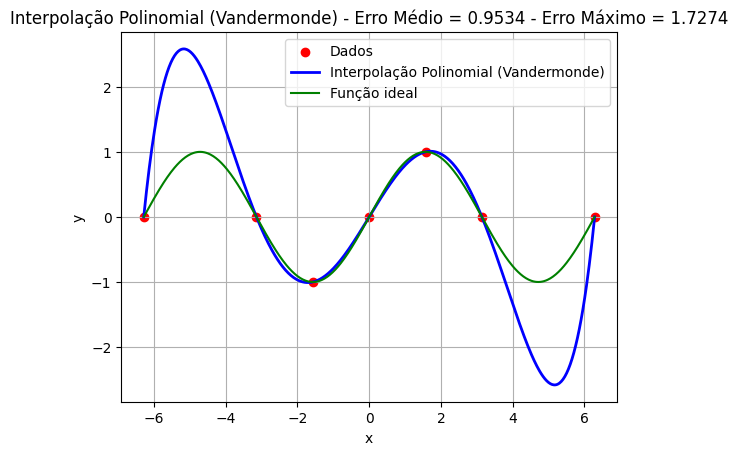

In [4]:
print('Exemplo 1')

x = [0, 1, 2, 3]
y = [1, 2, 0, 4]
print('\nSegue abaixo as coordenadas x e y dos pontos do exemplo 1')
print(x)
print(y)

p = vandermond_interp(x, y, plot= True)

teste = [1.5, 2.8, 3.9, 5.7, 9.1, 11.1, 15]
if p:
    for num in teste:
        print(f'O valor interpolado em {num} é p(num)={round(p(num),2)}')

print('\nNote que extrapolação é permitida')

print('\n--------------\n')
print('Exemplo 2')
print('\nPerceba que, mesmo ao mudar a ordem das coordenadas, o gráfico continua o mesmo')
x1 = [3, 0, 2, 1]
y1 = [4, 1, 0, 2]
print('\nSegue abaixo as coordenadas x e y dos pontos do exemplo 2')
print(x1)
print(y1)

f = vandermond_interp(x1, y1, plot = True)

print('\n--------------\n')
print('Exemplo 3')

f_ideal = lambda x : np.sin(x)
x2 = [-2*np.pi, -np.pi, -np.pi/2, 0, np.pi/2, np.pi, 2*np.pi]
y2 = [0, 0, -1, 0, 1, 0, 0]
print(x2)
print(y2)

g = vandermond_interp(x2, y2, plot = True, f_ideal=f_ideal)

# Código - Hermite

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

def _hermite_interp_mat(x_pontos: list, y_pontos: list, dy_pontos: list) -> Callable | None:
    """
    Função interna - Cria a função matemática da interpolação.
    
    Essa função apenas resolve o sistema linear e 
    retorna a função polinomial (Callable) que pode ser usada 
    para calcular valores.

    Parâmetros:
        x_pontos: Coordenadas x (n valores).
        y_pontos: Coordenadas y (n valores).
        dy_pontos: Derivadas dy/dx em cada x (n valores).

    Retorna:
        Uma função (Callable) que avalia o polinômio, ou None se der erro.
    """
    try:
        x_pts = np.asarray(x_pontos, dtype=float)
        y_pts = np.asarray(y_pontos, dtype=float)
        dy_pts = np.asarray(dy_pontos, dtype=float)
    except Exception as e:
        print(f"Erro ao converter entradas para arrays numpy: {e}")
        return None

    n = len(x_pts)
    if n == 0:
        print("Erro: As listas de pontos não podem estar vazias.")
        return None
    if len(y_pts) != n or len(dy_pts) != n:
        print("Erro: As listas x, y, e dy devem ter o mesmo tamanho.")
        return None
        
    num_coefs = 2 * n
    
    #valores min/max não são necessários para checagem, mas podem ser úteis se quiser saber o intervalo
    x_min = np.min(x_pts)
    x_max = np.max(x_pts)
    
    A = np.zeros((num_coefs, num_coefs))
    b = np.zeros(num_coefs)
    
    for i in range(n):
        x = x_pts[i]
        
        A[2*i] = [x**j for j in range(num_coefs)]
        b[2*i] = y_pts[i]
        
        linha_dy = [0.0] + [j * x**(j-1) for j in range(1, num_coefs)]
        A[2*i + 1] = linha_dy
        b[2*i + 1] = dy_pts[i]
    
    try:
        coefs = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print("Erro: Matriz singular. Verifique se há pontos x duplicados.")
        return None

    def polinomio_interpolador_hermite(x_novo: float | np.ndarray) -> float | np.ndarray:
        """
        Avalia o polinômio P(x_novo) = sum(c_j * x_novo^j)
        """
        x_val = np.asarray(x_novo, dtype=float)
        
        return np.polyval(coefs[::-1], x_val)
    
    return polinomio_interpolador_hermite

def _ordenar_coordenadas_hermite(x: list, y: list, dy: list) -> tuple:
    """
    Função interna - Ordena as coordenadas mantendo 'pareamento' para Hermite.

    Parâmetros:
    x: lista das coordenadas x, em x[i], de cada ponto i.
    y: lista das coordenadas y, em y[i], de cada ponto i.
    dy: lista das derivadas dy[i] em cada ponto i.

    Retorna:
    x_ord: lista das coordenadas x em ordem crescente.
    y_ord: lista das coordenadas y, pareadas com as coordenadas x.
    dy_ord: lista das derivadas, pareadas com as coordenadas x.
    """
    x_np = np.array(x)
    y_np = np.array(y)
    dy_np = np.array(dy)

    idx = np.argsort(x_np)

    x_ord = x_np[idx]
    y_ord = y_np[idx]
    dy_ord = dy_np[idx]

    return x_ord, y_ord, dy_ord

def _plotar_hermite(x: list, y: list, dy: list, f: Callable, titulo: str = "Interpolação de Hermite"):
    """
    Função interna - Plotagem de pontos, derivadas e da função de interpolação.

    Parâmetros:
    x: lista das coordenadas x, em x[i], de cada ponto i.
    y: lista das coordenadas y, em y[i], de cada ponto i.
    dy: lista das derivadas dy[i] em cada ponto i.
    f: função de interpolação que será plotada.
    titulo: título do gráfico.

    Retorna:
    None
    """
    #criar pontos para a curva suave
    x_min, x_max = min(x), max(x)
    
    #estende ligeiramente o plot para mostrar a extrapolação, se desejado
    #você pode ajustar 'padding' ou remover se preferir plotar só o intervalo
    padding = 0.1 * (x_max - x_min)
    if padding == 0: #caso de ponto único
        padding = 1.0
        
    x_curve = np.linspace(x_min - padding, x_max + padding, 500)
    y_curve = f(x_curve)
    
    #calcular as retas tangentes nos pontos de interpolação
    comprimento_tangente = 0.1 * (x_max - x_min) if (x_max - x_min) > 0 else 0.1
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    #gráfico principal
    ax.scatter(x, y, color='red', s=50, zorder=5, label='Pontos de dados')
    ax.plot(x_curve, y_curve, 'b-', linewidth=2, label='Polinômio de Hermite')
    
    #adc retas tangentes
    tangente_plotted = False
    for xi, yi, dyi in zip(x, y, dy):
        x_tang = [xi - comprimento_tangente, xi + comprimento_tangente]
        y_tang = [yi - comprimento_tangente * dyi, yi + comprimento_tangente * dyi]
        label = 'Tangente' if not tangente_plotted else ""
        ax.plot(x_tang, y_tang, 'g--', alpha=0.7, linewidth=1, label=label)
        if not tangente_plotted:
            tangente_plotted = True
        ax.plot(xi, yi, 'ro', markersize=8)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(titulo)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def hermite_interp(x_pontos: list, y_pontos: list, dy_pontos: list, 
                   titulo: str = "Interpolação de Hermite") -> Callable:
    """
    Cria e plota uma função de interpolação polinomial de Hermite.

    Parâmetros:
        x_pontos: Coordenadas x (n valores).
        y_pontos: Coordenadas y (n valores).
        dy_pontos: Derivadas dy/dx em cada x (n valores).
        titulo: Título para o gráfico.

    Retorna:
        Função de interpolação de Hermite.

    Notas:
        Sobre a Extrapolação:
        Esta função sempre permite a extrapolação (avaliar valores de x 
        fora do intervalo de dados [min(x_pontos), max(x_pontos)]). 
        O usuário é responsável por verificar os resultados, pois 
        polinômios podem crescer rapidamente e produzir valores
        imprevisíveis fora do intervalo de interpolação.
    """
    #ordenar coordenadas
    x_ord, y_ord, dy_ord = _ordenar_coordenadas_hermite(x_pontos, y_pontos, dy_pontos)
    
    #criar função de interpolação
    f_interp = _hermite_interp_mat(x_ord, y_ord, dy_ord)
    
    if f_interp is None:
        print("Erro: Não foi possível criar a função de interpolação.")
        return None
    
    #plot
    # A função de plot também vai mostrar um pouco da extrapolação
    _plotar_hermite(x_ord, y_ord, dy_ord, f_interp, titulo)

    #a lógica de restrição foi removida.
    
    return f_interp

Exemplo 1


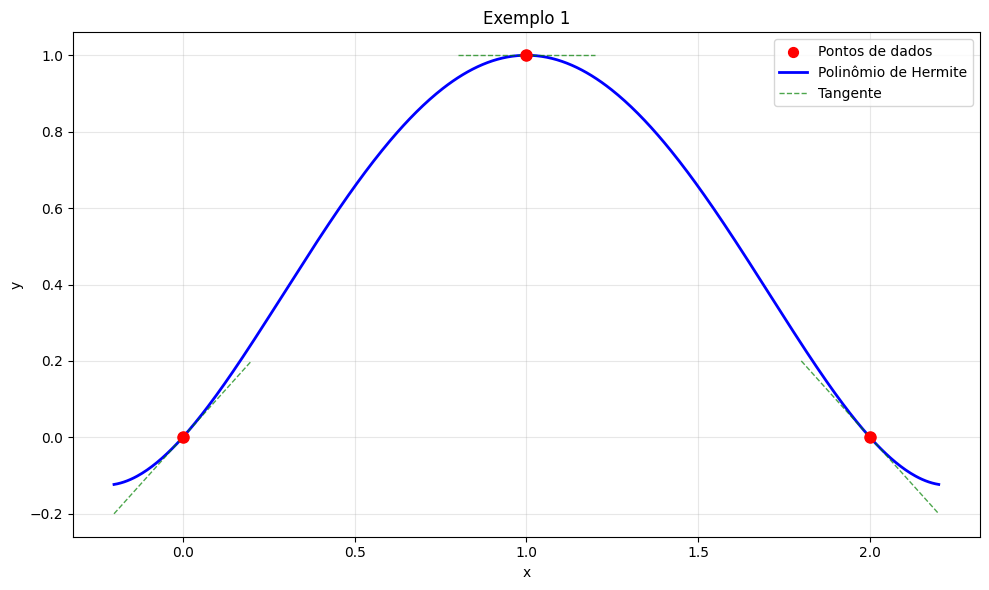

O valor interpolado em x=0.5 é: 0.6562
O valor interpolado em x=1.5 é: 0.6562


Exemplo 2


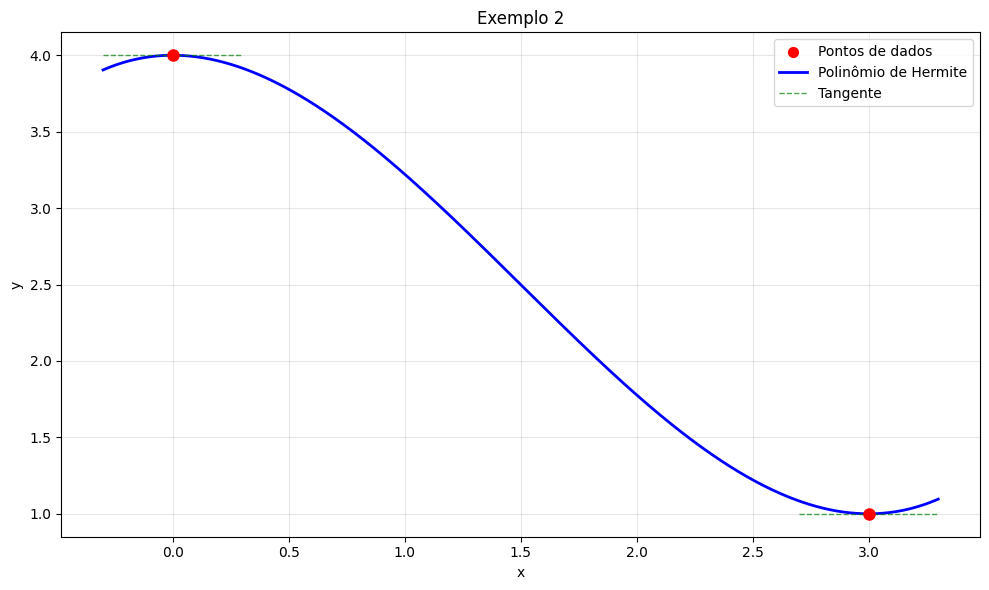

O valor interpolado em x=1.5 é: 2.5000


In [6]:
print("Exemplo 1")

x1 = [0, 1, 2]
y1 = [0, 1, 0]
dy1 = [1, 0, -1] 

p1 = hermite_interp(x1, y1, dy1, titulo="Exemplo 1")

if p1:
    print(f"O valor interpolado em x=0.5 é: {p1(0.5):.4f}")
    print(f"O valor interpolado em x=1.5 é: {p1(1.5):.4f}")
    
print("\n")
print("Exemplo 2")

x2 = [3, 0]
y2 = [1, 4]
dy2 = [0, 0] 

p2 = hermite_interp(x2, y2, dy2, titulo="Exemplo 2")

if p2:
    print(f"O valor interpolado em x=1.5 é: {p2(1.5):.4f}")